# Model Predictions and Evaluation

This notebook demonstrates the given models' predictions on a select few fundus images.

The models that you may test are:

- ```simple_vgg_015``` : This is a U-Net that uses the VGG as the encoder, this model was trained using binary class map weighting.
- ```csa_resnet_diceCE``` : This is a U-Net that uses the ResNet 50 as the encoder and uses compact split attention.

The predictions use images from the `images` folders, and the annotations from the `annotations-color` folder, please ensure the three zip files have been loaded into colab. Then run the next cell block to unzip. There are 8 images along with their associated annotations.



### Unzipping image and annotation folders

This code block unzips the uploaded files which contain the images and annotation maps. Run collapsed as this will prevent unnecessarily long unzipping output.

Please note that if this block is taking too long (>1 minute) to run, it could be due to the terminal asking a response from the user. In this case: 
- please expand this code block 
- select the input text field
- type 'All'
- hit enter

In [2]:
!unzip ./images.zip
!unzip ./annotations-color.zip
!unzip ./annotations-folder.zip

Archive:  ./images.zip
   creating: images/
  inflating: __MACOSX/._images       
  inflating: images/1077_right.jpg   
  inflating: __MACOSX/images/._1077_right.jpg  
  inflating: images/172_left.jpg     
  inflating: __MACOSX/images/._172_left.jpg  
  inflating: images/4374_right.jpg   
  inflating: __MACOSX/images/._4374_right.jpg  
  inflating: images/870_right.jpg    
  inflating: __MACOSX/images/._870_right.jpg  
  inflating: images/250_right.jpg    
  inflating: __MACOSX/images/._250_right.jpg  
  inflating: images/5450_left.jpg    
  inflating: __MACOSX/images/._5450_left.jpg  
  inflating: images/5063_right.jpg   
  inflating: __MACOSX/images/._5063_right.jpg  
  inflating: images/2802_right.jpg   
  inflating: __MACOSX/images/._2802_right.jpg  
Archive:  ./annotations-color.zip
   creating: annotations-color/
  inflating: __MACOSX/._annotations-color  
  inflating: annotations-color/1077_right.png  
  inflating: annotations-color/172_left.png  
  inflating: annotations-color/

##Installations and Imports

This section installs the necessary libraries and imports them, click arrow to run all. Do not expand, if expanded please collapse.

Along with libraries the following code blocks will install 2 model weight files which will be used in the code below. 

Please note this could take a short while.

In [8]:
!pip install miseval
!pip install gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 64.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 91.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 16.7 MB/s eta 0:00:00
  Created wheel for dictances: filename=dictances-1.5.6-py3-none-any.whl size=13534 sha256=564a8aee847184e8971e95dfb72e5929b7e895d13b03fcc781bf9683a973082c
  Stored in directory: /root/.cache/pip/wheels/cc/96/4d/91f2edcb5d2584367af01e025c786759fffe618127f10eadbd
  Created wheel for hausdorff: filename=hausdorff-0.2.6-py3-none-any.whl size=15209 sha256=4cbef974f84e76c1f4d39515fb37ca75951c623ae3ab3892182df4fc51ad1177
  Stored in directory: /root/.cache/pi

In [9]:
#Standard imports
import os
import math
import pathlib
import shutil
import matplotlib.pyplot as plt
import cv2
import numpy as np
from scipy.ndimage import rotate
import re
import random
#import segmentation_models as sm
#import segmentation_models_pytorch as sm
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from miseval import evaluate
from tqdm import tqdm
from PIL import Image
#Tensorflow imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import image_dataset_from_directory, img_to_array, load_img, array_to_img, save_img, to_categorical



In [10]:
#PyTorch imports
import torch
from torch.nn import functional as f
from torch.utils.data import TensorDataset, Dataset
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
from torchvision.transforms import functional as F
from torchvision import transforms
from torch import nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [11]:
!gdown https://drive.google.com/uc?id=1tSoyAJb43-HwpCGdMq_HsVxX1erJL3Gr
!gdown https://drive.google.com/uc?id=1dhCDHoCi6o51y7LrqHpTfiq2l5wTGGOY

Downloading...
From: https://drive.google.com/uc?id=1tSoyAJb43-HwpCGdMq_HsVxX1erJL3Gr
To: /content/simple_vgg_015.pth
100% 120M/120M [00:00<00:00, 144MB/s]
Downloading...
From: https://drive.google.com/uc?id=1dhCDHoCi6o51y7LrqHpTfiq2l5wTGGOY
To: /content/csa_resnet.pth
100% 142M/142M [00:01<00:00, 134MB/s]


## Initializations

The following code blocks initialize code for the models, and model loaders, please run collapsed code block, if expanded, collapse before running.

### Model Loader

In [12]:
def model_loader(model_specifications, num_classes):
    """This function returns a dictionary of loaded models.
    The model specification needs to be off the following form {\"name of model\" : (model_base, type, weights_path)}"""

    model_dict = {}

    for model_name in model_specifications.keys():

        base, simplicity, attention, subtractive, path = model_specifications[model_name]

        if base == 0:
            model = UNet(num_classes=num_classes, d_in=3,filters=[64, 128, 256, 512, 1024], simple=simplicity, attention=attention, subtractive=subtractive).to(device)
        elif base == 1:
            model = VGGUNet(num_classes, simplicity, attention=attention, subtractive=subtractive).to(device)
        elif base == 2:
            model = ResNetUNet(num_classes, simplicity, attention=attention, subtractive=subtractive).to(device)
        elif base == 3:
            model = EfficientNetUNet(num_classes, simplicity, attention=attention, subtractive=subtractive).to(device)
        elif base == 4:
            model = ArcEfficientNetUNet(num_classes, simplicity, attention, subtractive=subtractive).to(device)
        else:
            print("Unknown model base selected")
            return -1
        
        state_dict = torch.load(path, map_location=device)
        model.load_state_dict(state_dict)

        model_dict[model_name] = model
    
    return model_dict


### Base Model

In [13]:
class BaseModel():

    def predict(self, dataloader):
        """This function """
        self.eval()

        with torch.no_grad():
            
            predictions = []
            for images, _ in tqdm(dataloader):
                images = images.to(device)
                outputs = self(images)
                outputs = torch.nn.functional.softmax(outputs, dim=1)

                predictions.append(outputs.permute(0, 2, 3, 1))
            predictions = torch.cat(predictions, dim=0)
        
        return predictions.detach().cpu().numpy()
    
    def predict_binary(self, dataloader):
        """This function """
        self.eval()

        with torch.no_grad():
            
            predictions = []
            for images, _ in tqdm(dataloader):
                images = images.to(device)
                outputs = self(images)
                outputs = torch.sigmoid(outputs)
                predictions.append(outputs)
            predictions = torch.cat(predictions, dim=0)
        
        return predictions.detach().cpu().numpy()
    
    def predict_image(self, image):
        """This function returns the prediction of one image.
            image : torch.Tensor shape (3, w, h)
        """
        self.eval()
        with torch.no_grad():
            
            image = image.float()
            image = image.unsqueeze(0)
            image = image.to(device)
            output = self(image)
            output = torch.nn.functional.softmax(output, dim=1)
            output = output.detach().cpu().numpy()
            output = np.transpose(output, (0, 2, 3, 1))
            return output

### Decoder

In [14]:
class SimpleDecoderBlock(nn.Module):

    def __init__(self, d_in, d_out):

        super().__init__()

        self.upconv = nn.UpsamplingBilinear2d(scale_factor=2)
        self.conv_1 = nn.Conv2d(d_in, d_out, 1, 1)
        self.relu = nn.ReLU()
        self.conv_2 = nn.Conv2d(d_out*2, d_out, 3, 1, "same")
        self.bn1 = nn.BatchNorm2d(d_out)
        self.conv_3 = nn.Conv2d(d_out, d_out, 3, 1, "same")
        self.bn2 = nn.BatchNorm2d(d_out)

    def forward(self, inp, a):

        x = self.upconv(inp)
        x = self.relu(self.conv_1(x))

        if a is not None:

            x = torch.cat([a, x], axis=1)
            x = self.conv_2(x)
            x = self.bn1(x)
            x = self.relu(x)
            
        x = self.conv_3(x)
        x = self.bn2(x)
        x = self.relu(x)

        return x


class DecoderBlock(nn.Module):

    def __init__(self, d_in, d_out):


        super().__init__()
        self.upconv = nn.ConvTranspose2d(d_in, d_out, 2, 2)
        self.conv_1 = nn.Conv2d(d_out*2, d_out, 3, 1, "same")
        self.bn1 = nn.BatchNorm2d(d_out)
        self.relu = nn.ReLU()
        self.conv_2 = nn.Conv2d(d_out, d_out, 3, 1, "same")
        self.bn2 = nn.BatchNorm2d(d_out)
        

    def forward(self, inp, a):
        
        x = self.relu(self.upconv(inp))

        if a is not None:
            x = torch.cat([a, x], axis=1)
            x = self.conv_1(x)
            x = self.bn1(x)
            x = self.relu(x)
            
        x = self.conv_2(x)
        x = self.bn2(x)
        x = self.relu(x)

        return x


class Decoder(nn.Module):

    def __init__(self, d_in, filters, num_classes, simple=False, sigmoid=False, subtractive=False):

        super().__init__()

        self.decoder_blocks = []

        for f in filters:
            
            if simple:
                db = SimpleDecoderBlock(d_in, f)
            else:
                db = DecoderBlock(d_in, f)

            self.decoder_blocks.append(db)
            d_in = f
        
        self.dropout = nn.Dropout2d(p=0.2)
        self.sub = nn.Conv2d(f, 1, 1, 1) if subtractive else None
        self.output = nn.Conv2d(f, num_classes, 1, 1)
        self.decoder_blocks = nn.ModuleList(self.decoder_blocks)
        self.sig = nn.Sigmoid() if (sigmoid or subtractive) else None
    
    def forward(self, inputs, activations):

        x = inputs
        for db, a in zip(self.decoder_blocks, activations):

            x = db(x, a)
        
        if self.sub is None:
            output = self.output(x)
            if self.sig is not None:
                output = self.sig(output)
        else:
            bin_mask = self.sig(self.sub(x))
            weighted_features = bin_mask * x
            output = self.output(weighted_features)
        
        output = self.dropout(output)
            
        return output
        


### Attention

#### Dual Attention

In [15]:
import torch
from torch import nn

class SpatialAttention(nn.Module):

    def __init__(self, in_channels):

        super(SpatialAttention, self).__init__()

        self.C = in_channels

        self.alpha = nn.Parameter(torch.tensor(0.0))

        self.conv1 = nn.Conv2d(in_channels=self.C, out_channels=self.C, kernel_size=1, stride=1)
        self.conv2 = nn.Conv2d(in_channels=self.C, out_channels=self.C, kernel_size=1, stride=1)
        self.conv3 = nn.Conv2d(in_channels=self.C, out_channels=self.C, kernel_size=1, stride=1)
        self.relu = nn.ReLU()

    
    def forward(self, x):
        

        H = x.shape[2]
        W = x.shape[3]

        N = H * W

        a = x
        b = self.relu(self.conv1(x))
        c = self.relu(self.conv2(x))
        d = self.relu(self.conv3(x))

            

        b = b.view(-1, self.C, N)
        c = c.view(-1, self.C, N)
        d = d.view(-1, self.C, N)

        c = torch.bmm(c.transpose(1, 2), b)
        S = nn.Softmax(dim=1)(c)
        S = S.transpose(1, 2)

        d = self.alpha * torch.bmm(d, S)
        d = d.view(-1, self.C, H, W)
        E = a + d

        return E


class ChannelAttention(nn.Module):

    def __init__(self, in_channels):

        super(ChannelAttention, self).__init__()
        self.beta = nn.Parameter(torch.tensor(0.0))

        self.C = in_channels
    
    def forward(self, x):

        a1=a2=a3=a4 = x
        H = x.shape[2]
        W = x.shape[3]
        N = H * W

        a2 = a2.view(-1, self.C, N)
        a3 = a3.view(-1, self.C, N)
        a4 = a4.view(-1, self.C, N)
        a4 = a4.transpose(1, 2)

        aa_T = torch.bmm(a3, a4)
        X = nn.Softmax(dim=1)(aa_T)
        X = X.transpose(1, 2)

        a2_pass = torch.bmm(X, a2) * self.beta
        a2_pass = a2_pass.view(-1, self.C, H, W)

        E = a1 + a2_pass

        return E

class DualAttention(nn.Module):

    def __init__(self, in_channels):
        
        super(DualAttention, self).__init__()
        self.C = in_channels

        self.conv1 = nn.Conv2d(self.C, self.C, 1)
        self.conv2 = nn.Conv2d(self.C, self.C, 1)

        self.sam = SpatialAttention(in_channels)
        self.cam = ChannelAttention(in_channels)

    def forward(self, x):

        e1 = self.sam(x)
        e2 = self.sam(x)

        e1 = self.conv1(e1)
        e2 = self.conv2(e2)

        F = e1 + e2
        return F

#### CSA

In [16]:
class CSA(nn.Module):

    def __init__(self, in_channels):
        
        super(CSA, self).__init__()

        self.C = in_channels
        self.C_by_2 = int(in_channels / 2)
        self.conv_1 = nn.Conv2d(in_channels, in_channels, 1)
        self.conv_3x3_1 = nn.Conv2d(in_channels=self.C_by_2, out_channels=self.C_by_2, kernel_size=3, stride=1, padding="same")
        self.conv_3x3_2 = nn.Conv2d(in_channels=self.C_by_2, out_channels=self.C_by_2, kernel_size=3, stride=1, padding="same")
        self.conv_3x3_3 = nn.Conv2d(in_channels=in_channels, out_channels=self.C_by_2, kernel_size=3, stride=1, padding="same")

        self.group_1 = nn.Conv2d(in_channels=in_channels, out_channels=in_channels, kernel_size=1, stride=1)
        self.bn = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU()
        self.group_2 = nn.Conv2d(in_channels=in_channels, out_channels=in_channels, kernel_size=1, stride=1)
        self.softmax = nn.Softmax(dim=1)
        self.final_conv = nn.Conv2d(in_channels=in_channels, out_channels=in_channels, kernel_size=1, stride=1)

    def forward(self, input):

        H = input.shape[2]
        W = input.shape[3]

        N = H * W

        F = self.conv_1(input)
        F_1, F_2 = F.split(int(self.C / 2), dim=1)

        F_1 = self.conv_3x3_1(F_1)
        F_2 = self.conv_3x3_2(F_2)
        F_2 = torch.concat([F_1, F_2], dim=1)
        F_2 = self.conv_3x3_3(F_2)

        F = torch.concat([F_1, F_2], dim=1)

        #Global average pooling
        F = nn.AdaptiveAvgPool2d((H, W))(F)

        F = self.group_1(F)
        F = self.bn(F)
        F = self.relu(F)
        F = self.group_2(F)

        F_1_s, F_2_s = F.split(int(self.C / 2), dim=1)

        F_1_s = self.softmax(F_1)
        F_2_s = self.softmax(F_2)

        F_1_final = F_1 * F_1_s
        F_2_final = F_2 * F_2_s

        F_final = torch.concat([F_1_final, F_2_final], dim=1)
        F_final = self.final_conv(F_final)

        output = F_final + input

        return output

### VGG U-Net

In [17]:
from torchvision.models import vgg19, VGG19_Weights


class VGGUNet(nn.Module, BaseModel):

    def __init__(self, num_classes, simple=False, sigmoid=False, attention=False, subtractive=False):

        super().__init__()
        
        vgg19_m = vgg19(weights=VGG19_Weights.DEFAULT)
        self.vgg = nn.Sequential(*(list(vgg19_m.children())[0][:-1]))
        for param in self.vgg.parameters():
            param.requires_grad = False
            
        self.vgg = self.vgg.to(device)
        self.activations = []

        self.filters = [512, 256, 128, 64]
        self.decoder = Decoder(self.filters[0], self.filters, num_classes, simple=simple, sigmoid=sigmoid, subtractive=subtractive)

        self.attention = attention
        if attention == 1:
            self.dual_attention = CSA(self.filters[0])
            self.dual_attention_2 = CSA(self.filters[0])
        elif attention == 2:
            self.dual_attention = DualAttention(self.filters[0])
            self.dual_attention_2 = DualAttention(self.filters[0])
        elif attention > 2 or attention < 0:
            print("Print attention can only be 0, 1, or 2")
            return -1
        else:
            pass
                                           

    
    def getActivations(self):
        def hook(model, input, output):
            self.activations.append(output)
        return hook
    
    def forward(self, input):

        self.activations = []

        h1 = self.vgg[3].register_forward_hook(self.getActivations())
        h2 = self.vgg[8].register_forward_hook(self.getActivations())
        h3 = self.vgg[17].register_forward_hook(self.getActivations())
        h4 = self.vgg[26].register_forward_hook(self.getActivations())

        vgg_output = self.vgg(input)

        if self.attention:
            vgg_output = self.dual_attention(vgg_output)
            self.activations[-1] = self.dual_attention_2(self.activations[-1])

        final_output = self.decoder(vgg_output, self.activations[::-1])

        h1.remove()
        h2.remove()
        h3.remove()
        h4.remove()

        return final_output


### ResNet U-Net

In [18]:
from torchvision.models import resnet50, ResNet50_Weights

class ResNetUNet(nn.Module, BaseModel):

    def __init__(self, num_classes, simple=False, sigmoid=False, attention=False, subtractive=False):

        super().__init__()

        self.activations = [None]
        resnet_model = resnet50(weights=ResNet50_Weights.DEFAULT)

        self.resnet_backbone = nn.Sequential(*(list(resnet_model.children())[0:7]))
        for param in self.resnet_backbone.parameters():
            param.requires_grad = False

        filters = [512, 256, 64, 64]
        self.decoder = Decoder(1024, filters, num_classes, simple=simple, sigmoid=sigmoid, subtractive=subtractive)
        self.attention = attention
        if attention == 1:
            self.dual_attention = CSA(1024)
            self.dual_attention_2 = CSA(filters[0])
        elif attention == 2:
            self.dual_attention = DualAttention(1024)
            self.dual_attention_2 = DualAttention(filters[0])
        elif attention > 2 or attention < 0:
            print("Attention can only be 0, 1, or 2")
            return -1
        else:
            pass
    
    def getActivations(self):
        def hook(model, input, output):
            self.activations.append(output)
        return hook
    
    def forward(self, input):

        self.activations = [None]

        hr1 = self.resnet_backbone[2].register_forward_hook(self.getActivations())
        hr2 = self.resnet_backbone[4][2].register_forward_hook(self.getActivations())
        hr3 = self.resnet_backbone[5][-1].register_forward_hook(self.getActivations())

        resnet_output = self.resnet_backbone(input)
        
        if self.attention:
            resnet_output = self.dual_attention(resnet_output)
            self.activations[-1] = self.dual_attention_2(self.activations[-1])

        final_output = self.decoder(resnet_output, self.activations[::-1])

        hr1.remove()
        hr2.remove()
        hr3.remove()

        return final_output

### Evaluation Pipeline

In [19]:
import json
class EvalPipeline:
    
    def __init__(self, dataloader, n,model_dict, class_dict, color_dict):
        
        """"This is an evaluation pipeline which can be used to determine the evaluation metrics for a group of segmentation models."""

        self.dl = dataloader
        self.img, self.gt = zip(*[(data[0].numpy(), data[1].numpy()) for data in dataloader])
        self.img = np.concatenate(self.img)
        #For the methods defined below, the ground-truths need to be in the following shape : (B, H, W, 1)
        self.gt = np.concatenate(self.gt)
            
        self.clf_gt = torch.from_numpy(self.gt)
        self.clf_gt = f.max_pool2d(self.clf_gt, self.clf_gt.shape[2:])
        self.clf_gt = torch.squeeze(torch.squeeze(self.clf_gt, dim=-1), dim=-1).to(torch.int)
        
        self.gt = np.transpose(self.gt, (0, 2, 3, 1))
        self.gt = np.argmax(self.gt, axis=3)
        self.gt = np.expand_dims(self.gt, axis=-1)
        
        self.model_dict = model_dict
        self.n = n
        self.class_dict = class_dict
        self.color_dict = color_dict
        self.prediction_gen()
        
    def prediction_gen(self):

        """Generates predictions for each segmentation model"""
        
        predictions = {}
        profiles = {}
        
        for m in self.model_dict.keys():
            model = self.model_dict[m]

            #For the methods below, the predictions need to be in the following shape : (B, H, W, 1)
            pred = model.predict(self.dl)
            
            #Getting the lesion profiles from predictions
            profile = torch.from_numpy(pred)
            profile = profile.permute(0,3,1,2)
            clf_pred = f.max_pool2d(profile, profile.shape[2:])
            clf_pred = torch.squeeze(torch.squeeze(clf_pred, dim=-1), dim=-1)
            clf_pred = torch.round(clf_pred).to(torch.int)
            
            profiles[m] = clf_pred
            
            pred = np.argmax(pred, axis=-1)
            pred = np.expand_dims(pred, axis=-1)
            
            predictions[m] = pred
            
        self.pred = predictions
        self.clf_preds = profiles
    
    def exact_match_ratio(self, predictions, targets, threshold=0.5):
        """
        :param predictions: tensor of shape (batch_size, num_classes) with predicted scores
        :param targets: tensor of shape (batch_size, num_classes) with target scores
        :return: exact match ratio
        """
        # binarize predictions using threshold
        binary_predictions = torch.where(predictions > threshold, 1, 0)
        # calculate element-wise equality between binary predictions and targets
        equality = torch.eq(binary_predictions, targets)
        # calculate row-wise sums of element-wise equality
        row_sums = torch.sum(equality, dim=1)
        # calculate exact match ratio
        exact_match_ratio = torch.mean(torch.eq(row_sums, targets.shape[1]).float())
        return exact_match_ratio
    
    def jaccard(self, predictions, targets, threshold=0.5):

        binary_predictions = torch.where(predictions > threshold, 1, 0)
        #Calculate the intersection between predictions and targets, sum in the class dimension
        intersection = torch.sum(binary_predictions * targets, dim=1)
        union = torch.sum((binary_predictions | targets), dim=1)

        jaccard_score = torch.mean(intersection.float() / union.float())
        return jaccard_score
    #This function swaps colors from a class map
    def color_swap(self, img):
    
        for key in self.color_dict.keys():

            c = np.where(img[:, :, [0,1,2]] == [key, key, key])
            img[c[0], c[1], :] = self.color_dict[key]

        return img
    
    def image_overlay(self, img, ann):
        
        """This function overlays the annotation over the image
        This function assumes that the background color is pixel value (0,0,0) in RGB
        img : numpy array in the shape : (height, width, color, alpha)
        ann : numpy array in the shape : (height, width, color, alpha)"""
        
        c = np.where(ann[:,:,[0,1,2]] == [0,0,0])
        c_2 = np.where(ann[:,:,[0,1,2]] != [0,0,0])
        ann[c[0], c[1],-1] = 0
        ann[c_2[0], c_2[1],-1] = 100
        
        img = Image.fromarray(img)
        ann = Image.fromarray(ann)
        
        #Overlaying the annotation on the image
        img.paste(ann, (0,0), ann)
        img = np.array(img)
        
        return img
            
    
    def stage_one(self, metrics=["SENS", "SPEC", "IoU", "DSC"], model_keys=[], path="stage_1.csv"):
        
        scores = {}
        
        #First evaluate the same metric for all sets of predictions
        print(metrics)
        for metric in metrics:
            
            scores[metric] = []
            for p in model_keys:
                
                
                current_pred = self.pred[p]
                #Evaluate for the current prediction
                score = evaluate(self.gt, current_pred, metric=metric, multi_class=True, n_classes=self.n)
                score = np.round(np.mean(score), 3)
                scores[metric].append(score)
                
        with open(path, "w") as f:
            f.write("model,")
            for m in metrics:
                f.write(m)
                f.write(",")
            f.write("\n") 
            for i in range(len(scores[m])):
                f.write(model_keys[i])
                f.write(",")
                for m in metrics:

                    f.write(str(round(scores[m][i],3)))
                    f.write(",")
                f.write("\n")
            
            
        return scores
    
    def stage_two(self, metrics=["SENS", "SPEC", "IoU", "DSC"], model_keys=[], path="stage_2.json", csv_path="stage_2.csv"):
        
        scores = {}
        
        # Have to change all of done_pred instances into self.pred
        for p in model_keys:
            scores[p] = []
            print(f"Working on : {p}...")
            for metric in metrics:
                
                current_pred = self.pred[p]
                #Evaluate for the current prediction
                score = evaluate(self.gt, current_pred, metric=metric, multi_class=True, n_classes=self.n)
                scores[p].append(np.round(score, 3))
            
            scores[p] = np.array(scores[p]).T
        
        scores_2 = {}
        
        print("Creating final dict")
        with open(csv_path, "w") as csv_file:
            
            #Writing the csv headers
            csv_file.write("model_name")
            csv_file.write(",")
            csv_file.write("class")
            csv_file.write(",")
            
            for metric in metrics:
                csv_file.write(metric)
                csv_file.write(",")
            
            csv_file.write("\n")
            
            for p in model_keys:
                scores_2[p] = {}
                
                for i, c in enumerate(self.class_dict):
                    scores_2[p][c] = {}
                    
                    #Starting off the row
                    csv_file.write(p)
                    csv_file.write(",")
                    csv_file.write(c)
                    csv_file.write(",")
                    
                    for n, m in enumerate(metrics):

                        #p : model type
                        #c : class
                        #m : metric
                        
                        #Writing in each metric
                        csv_file.write(str(round(scores[p][i][n],3)))
                        csv_file.write(",")
                        
                        scores_2[p][c][m] = scores[p][i][n]
                    
                    csv_file.write("\n")
                        
                    
        
        

        with open(path, "w") as json_file:
            json.dump(scores_2, json_file)
        
        
        return scores_2
    
    def stage_three(self, img_dir, gt_dir, img_files, gt_files, model_keys=[],path="stage_3.png"):
        
        assert len(img_files) == len(gt_files)
        n_cols = len(img_files)
        n_rows = len(model_keys) + 1
        
        #Defining the figure
        fig, ax = plt.subplots(n_cols, n_rows, figsize=(n_rows*3,n_cols*3))
        
        #Plotting the ground truth overlayed on the image
        for i, (img, ann) in enumerate(zip(img_files, gt_files)):
            
            
            
            img_path = os.path.join(img_dir, img)
            image = cv2.imread(img_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGBA)
            
            gt_path = os.path.join(gt_dir, ann)
            gt = cv2.imread(gt_path)
            gt = cv2.cvtColor(gt, cv2.COLOR_BGR2RGBA)
            
            overlay_img = self.image_overlay(image, gt)
            overlay_img = cv2.cvtColor(overlay_img, cv2.COLOR_RGBA2RGB)
            ax[i, 0].imshow(overlay_img)
            ax[i, 0].set_xlabel("ground truth")
            ax[i, 0].set_xticks([])
            ax[i, 0].set_yticks([])
        
        for i, model_name in enumerate(model_keys):
            
            i = i+1
            model = self.model_dict[model_name]
            
            for n, img in enumerate(img_files):
                
                img_path = os.path.join(img_dir, img)
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, (512, 512))
                image = image / 255.0
                image = np.transpose(image, (2, 0, 1))
                image = torch.from_numpy(image).float()
                
                pred = model.predict_image(image)
                pred = np.clip(pred, a_min=0.5, a_max=1)
                pred = np.argmax(pred, axis=-1)
                pred = np.transpose(pred, (1,2,0))
                pred = np.repeat(pred, repeats=3,axis=-1)
                pred = self.color_swap(pred)
                pred = np.uint8(pred)
                pred = cv2.cvtColor(pred, cv2.COLOR_RGB2RGBA)

                
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGBA) 
                image = cv2.resize(image, (512, 512))
                
                overlayed_prediction = self.image_overlay(image, pred)
                overlayed_prediction = cv2.cvtColor(overlayed_prediction, cv2.COLOR_RGBA2RGB)
                
                ax[n, i].imshow(overlayed_prediction)
                ax[n, i].set_xticks([])
                ax[n, i].set_yticks([])
                ax[n, i].set_xlabel(model_name)
        
        plt.subplots_adjust(left=0.2,
                    right=0.9,
                    wspace=0.4,
                    hspace=0.4)
            
        plt.savefig(path, dpi=100)
                    
    
    def stage_four(self, img_dir, gt_dir, img_files, gt_files, model_keys=[],path="stage_4.png"):
        
        """This method is used to compare the predictions of the models passed in with the ground truth for all the images passed in as arguments into this function.
        img_dir : this is the directory of the images : string
        gt_dir : this is the directory where the ground truth images are present : string
        img_files : the specific image file names choosen to plot : list of strings
        gt_files : the corresponding ground truth files choosen to comapare against : list of strings
        The img_files and gt_files must be present within the img_dir and gt_dir respectively.
        Furthermore, the same number of image files and ground truth files should be passed in.
        """
        
        #Number of images should be the same as G.T
        assert len(img_files) == len(gt_files)
        print(img_dir)
        print(gt_dir)
        print(img_files)
        print(gt_files)
        
        n_cols = len(img_files)
        n_rows = len(model_keys) +2
        
        #Defining the figure
        fig, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols*3,n_rows*3))
        
        ax[0, 0].set_ylabel("images")
        ax[1, 0].set_ylabel("ground_truth")
        
        #Plotting the images first
        for i, img in enumerate(img_files):
            
            img_path = os.path.join(img_dir, img)
            image = cv2.imread(img_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            ax[0, i].imshow(image)
            
            ax[0,i].set_xticks([])
            ax[0, i].set_yticks([])
        
        #Plotting the ground truth
        for i, ann in enumerate(gt_files):
            
            gt_path = os.path.join(gt_dir, ann)
            gt = cv2.imread(gt_path)
            gt = cv2.cvtColor(gt, cv2.COLOR_BGR2RGB)
            #gt = cv2.resize(gt, (512, 512))

            ax[1, i].imshow(gt)
            
            ax[1,i].set_xticks([])
            ax[1, i].set_yticks([])
        
        for i, model_name in enumerate(model_keys):
            
            i = i+2
            model = self.model_dict[model_name]
            ax[i, 0].set_ylabel(model_name)
            
            for n, img in enumerate(img_files):
                
                img_path = os.path.join(img_dir, img)
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, (512, 512))
                image = image / 255.0
                image = np.transpose(image, (2, 0, 1))
                image = torch.from_numpy(image).float()
                
                pred = model.predict_image(image)
                pred = np.clip(pred, a_min=0.5, a_max=1)
                pred = np.argmax(pred, axis=-1)
                pred = np.transpose(pred, (1,2,0))
                pred = np.repeat(pred, repeats=3,axis=-1)
                pred = self.color_swap(pred)
                
                ax[i, n].imshow(pred)
                ax[i,n].set_xticks([])
                ax[i,n].set_yticks([])
            
        plt.subplots_adjust(left=0.2,
                    right=0.9,
                    wspace=0.4,
                    hspace=0.4)
            
        plt.savefig(path, dpi=100)
    ### Stage 5 : F1 score plots per model per class
    
    def stage_five(self, model_keys=[],path="stage_5.png", csv_path="stage_5.csv"):
        
        f1_scores = {}
        
        markers = ["x", "+", ".", "1", "*", "d"]
        colors = ["lime", "fuchsia", "darkorange", "gold", "salmon", "indigo"]
        
        model_names = model_keys
        
        
        if len(model_names) <= 6:
            
            fig, ax = plt.subplots(1,1, figsize=(6,self.n))
            ys = range(self.n)
        
        for i, model_name in enumerate(model_names):
            
            pred = self.pred[model_name]
            
            prec = evaluate(self.gt, pred, metric="PREC", multi_class=True, n_classes=self.n)
            recall = evaluate(self.gt, pred, metric="Recall", multi_class=True, n_classes=self.n)
            
            f1 = (2 * prec * recall) / (prec + recall)
            f1_scores[model_name] = np.round(f1, 3)
            
            some_num = np.random.uniform(0.1, 0.3, 1)
            
            if len(model_names) <= 6:
                ax.scatter(x=f1, y=ys, color=colors[i], marker=markers[i], label=model_name)
                ax.set_yticks(ticks=list(range(self.n)),labels=self.class_dict)
                ax.legend(loc="best")
                ax.grid()

        
        with open(csv_path, "w") as f:
            
            f.write("Model,")
            for class_name in self.class_dict:
                f.write(class_name)
                f.write(",")
                
            f.write("\n")
            
            for i, model_name in enumerate(model_names):
                
                f.write(model_name)
                f.write(",")
                
                f1_score = f1_scores[model_name]
                
                for f1 in f1_score:
                    f.write(str(round(f1,3)))
                    f.write(",")
                    
                f.write("\n")
                
        if len(model_names) <= 6:            
            plt.savefig(path, dpi=100, bbox_inches="tight")

    
    
    def stage_six(self, model_keys=[], path="./stage_6.csv"):
        scores = {}
        for i, model_name in enumerate(model_keys):
            
            clf_pred = self.clf_preds[model_name]

            js = np.round(self.jaccard(clf_pred, self.clf_gt).numpy(), 3)
            emr_score = np.round(self.exact_match_ratio(clf_pred, self.clf_gt).numpy(), 3) 

            scores[model_name] = [js, emr_score]
        
        with open(path, "w") as s6:

            s6.write("Model")
            s6.write(",")
            s6.write("Jaccard")
            s6.write(",")
            s6.write("Exact Match Ratio")
            s6.write(",")
            s6.write("\n")

            for i, model_name in enumerate(model_keys):

                s6.write(model_name)
                s6.write(",")

                #Write the jaccard score and exact match ratio
                for metric in scores[model_name]:
                    s6.write(str(round(metric,3)))
                    s6.write(",")

                s6.write("\n")
    def stage_seven(self, model_key, path="./s7.png"):
        
        gt = self.gt.reshape(-1)
        model_pred = self.pred[model_key].reshape(-1)
        
        fig, ax = plt.subplots(1,1, figsize=(12,12))
        
        ConfusionMatrixDisplay.from_predictions(
                                        gt
                                        , model_pred
                                        , display_labels=self.class_dict
                                        , xticks_rotation=45
                                        , normalize='true'
                                        , values_format= ".3%"
                                        , cmap="YlGnBu"
                                        ,ax=ax)

        plt.savefig(path, bbox_inches="tight")
        
        
        

        
        
        


### Evaluation Runner


In [20]:
class Evaluator:
    
    def __init__(self, eval_pipeline, results_dir):
        
        self.eval_pipeline = eval_pipeline
        self.results_dir = results_dir
    
    def handle_one_or_six(self, routine, args):
        
        if len(args) == 2:
            keys, path = args
            path = os.path.join(self.results_dir, path)
            #Either stage 1 of evaluation or stage 6
            if routine == 1:
                self.eval_pipeline.stage_one(model_keys=keys, path=path)
            else:
                self.eval_pipeline.stage_six(keys, path)
        else:
            mets, keys, path = args
            path = os.path.join(self.results_dir, path)
            self.eval_pipeline.stage_one(mets, keys, path)
    
    def handle_two_or_five(self, routine, args):
        
        if len(args) == 3:
            keys, path, csv_path = args
            path = os.path.join(self.results_dir, path)
            csv_path = os.path.join(self.results_dir, csv_path)
            if routine == 2:
                self.eval_pipeline.stage_two(model_keys=keys, path=path, csv_path=csv_path)
            else:
                self.eval_pipeline.stage_five(keys, path, csv_path)
        else:
            mets, keys, path, csv_path = args
            path = os.path.join(self.results_dir, path)
            csv_path = os.path.join(self.results_dir, csv_path)
            self.eval_pipeline.stage_two(mets, keys, path, csv_path)
            
            
    def handle_three_or_four(self, routine, args):
        
        img_dir, gt_dir, img_files, gt_files, keys, path = args    
        path = os.path.join(self.results_dir, path)
        
        if routine == 3:
            self.eval_pipeline.stage_three(img_dir, gt_dir, img_files, gt_files, keys, path)
        else:
            self.eval_pipeline.stage_four(img_dir, gt_dir, img_files, gt_files, keys, path)

    def quantative(self, stub_name, model_keys):

        s1_ext = stub_name + "_s1.csv"     
        s2_ext = stub_name + "_s2.json"
        s2_csv_ext = stub_name + "_s2.csv"
        s5_ext = stub_name + "_s5.png"
        s5_csv_ext = stub_name + "_s5.csv"
        s6_ext = stub_name + "_s6.csv"

        quant_routine = {

            1 : (model_keys, s1_ext),
            2 : (model_keys, s2_ext, s2_csv_ext),
            5 : (model_keys, s5_ext, s5_csv_ext),
            6 : (model_keys, s6_ext)
        }

        self.evaluate(quant_routine)
    
    def qualitative(self, stub_name, model_keys, args):

        img_dir, gt_dir, img_files, gt_files = args
        
        s3_ext = stub_name + "_s3.png"
        s4_ext = stub_name + "_s4.png"

        qual_routine = {
            3: (img_dir, gt_dir, img_files, gt_files, model_keys, s3_ext),
            4 : (img_dir, gt_dir, img_files, gt_files, model_keys, s4_ext)
        }

        self.evaluate(qual_routine)
    
    def all_routines(self, stub_name, model_keys, args):

        self.quantative(stub_name, model_keys)
        self.qualitative(stub_name, model_keys, args)
    
    def evaluate(self, eval_routines):
        
        """This function will run the specified evaluation routines that are present in the evaluation pipeline, it is a helper class.
        eval_routines : dictionary, the keys are numbers from 1-5 specifying which evaluation routines should be run, the values to the keys are the arguments required for that function in the evaluation pipeline"""
        
        for routine in eval_routines.keys():
            
            args = eval_routines[routine]
            if routine == 1 or routine == 6:
                
                self.handle_one_or_six(routine, args)

            elif routine == 2 or routine == 5:
                
                self.handle_two_or_five(routine, args)            
                    
            elif routine == 3 or routine == 4:
                
                self.handle_three_or_four(routine, args)
            
            else:
                
                print("Invalid routine")
                return -1

                

### Data Pipeline

In [21]:
class MultiClassSegmentationDataset(Dataset):
    
    def __init__(self, image_files, mask_dirs, size, classes,n_classes, background=True, test_mode=False, binary_index=None):
        
        assert len(image_files) == len(mask_dirs)
        
        self.image_files = sorted(image_files)
        self.mask_dirs = sorted(mask_dirs)
        self.annotation_files = {}
        
        for img_fldr in self.mask_dirs:
            self.annotation_files[img_fldr] = sorted(os.listdir(img_fldr))
            
        self.H = size
        self.W = size
        self.n = n_classes
        self.classes = dict(zip(sorted(classes), range(n_classes)))
        self.background = background
        self.test_mode = test_mode
        self.binary_index = binary_index

    
    def __len__(self):
        
        return len(self.image_files)

    def __getitem__(self, idx):
        
        #Reading the image
        img_path = self.image_files[idx]

        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (self.H,self.W))
        #norm_img = cv2.normalize(img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        norm_img = img / 255.0
        norm_img = np.transpose(norm_img, (2, 0, 1))
        img_tensor = torch.from_numpy(norm_img)
        img_tensor = img_tensor.float()
        
        
        #Preparing mask - There are 4 lesion classes, the directories have 1 picture each for a specific lesion, have to combine them
        #1 extra class for the background
        #The background mask is currently all ones, the ones from each class have to be subtracted from it
        background = np.ones((self.H, self.W))
        mask = np.zeros((self.n + 1, self.H, self.W))
        ann_fldr = self.mask_dirs[idx]
        ann_files = self.annotation_files[ann_fldr]
        for ann_file in ann_files:

            code = ann_file[:-4]
            ix = self.classes[code]
            ann_path = os.path.join(ann_fldr, ann_file)
            ann = cv2.imread(ann_path, 0)
            ann = cv2.resize(ann, (self.H, self.W), cv2.INTER_NEAREST)
            #update background by subtracting the current pixel positions
            background = background - ann
            
            ann = np.expand_dims(ann, axis=0)
            
            mask[ix+1, :, :] = ann
        
        #If there are overlapping pixel values, the pixel value at a certain position may be negative, have to clip to 0
        background = np.clip(background, 0, None)
        background = np.expand_dims(background, axis=0)
        #Place the background class inside
        if self.background:
            mask[0,:,:] = background
        
        mask_tensor = torch.from_numpy(mask)
        mask_tensor = mask_tensor.float()
        
        if not self.test_mode:
            #Data augmentation if it's not test_mode, for example training and validation data will get augmented
            augment_mode = np.random.randint(0,4)
            if augment_mode == 0:
                img_tensor = F.hflip(img_tensor)
                mask_tensor = F.hflip(mask_tensor)
            elif augment_mode == 1:
                img_tensor = F.vflip(img_tensor)
                mask_tensor = F.vflip(mask_tensor)
            elif augment_mode == 2:
                angle = np.random.randint(-5, 5)
                img_tensor = F.rotate(img_tensor, angle)
                mask_tensor = F.rotate(mask_tensor, angle)

        if self.binary_index is not None:
            mask_tensor = mask_tensor[self.binary_index]
            
        return img_tensor, mask_tensor
        
        
                
        
        

## Dataset Generation

The following section contains code which initializes pytorch Dataset objects to be used for predictions and evaluations. 

Due to the way files are generated on a mac, there is a slight chance that an error can be raised in this section.


### File Path Initializations

In [44]:
image_dir = "./images/"
#enhanced_image_dir = "./enhancement_one_x/"
enhanced_image_dir = "./images/"
annotations_dir = "./annotations-folder/"

image_files = sorted(list(os.listdir(image_dir)))
image_files = sorted([os.path.join(enhanced_image_dir, file_name) for file_name in image_files])


annotation_files = sorted(list(os.listdir(annotations_dir)))
annotation_files.remove(".DS_Store")
annotation_files = sorted([os.path.join(annotations_dir, file_name) for file_name in annotation_files])

try:
  assert len(image_files) == len(annotation_files)
except:
  image_files.remove("./images/.DS_Store")
  assert len(image_files) == len(annotation_files)


train_img, tv_img, train_anns, tv_anns = train_test_split(image_files, annotation_files, test_size=0.5, random_state=99)
mismatch = [file[:-4] for file in image_files if file in annotation_files]
valid_img, test_img, valid_anns, test_anns = train_test_split(tv_img, tv_anns, test_size=0.5, random_state=99)

classes = sorted(["cotton_wool_spots", "hard_exudate", "retinal_hemorrhage", "microaneurysm"])

print(f"There are {len(train_img)} training images and annotations")
print(f"There are {len(valid_img)} validation images and annotations")
print(f"There are {len(test_img)} test images and annotations")

There are 4 training images and annotations
There are 2 validation images and annotations
There are 2 test images and annotations


### Dataset Generation

In [45]:
train_ds = MultiClassSegmentationDataset(train_img, train_anns, size=512, classes=classes, n_classes=4)
train_dl = DataLoader(train_ds, shuffle=True, batch_size=4 ,pin_memory=True, num_workers=os.cpu_count())

valid_ds = MultiClassSegmentationDataset(valid_img, valid_anns, size=512, classes=classes, n_classes=4)
valid_dl = DataLoader(valid_ds, shuffle=True, batch_size=4 ,pin_memory=True, num_workers=os.cpu_count())

test_ds = MultiClassSegmentationDataset(test_img, test_anns, size=512, classes=classes, n_classes=4, test_mode=True)
test_dl = DataLoader(test_ds, shuffle=False, batch_size=4, pin_memory=True, num_workers=os.cpu_count())

## Model Loading

The following cell is used to load the two downloaded models.

In [24]:
#Creating the model specification for the model loader - this specification tells the loader what kind of model is required
model_spec = {
    "simple_vgg_bcm_unet" : (1,1,0,0, "./simple_vgg_015.pth"),
    "csa_resnet_unet" : (2,1,1,0, "./csa_resnet.pth")
}

#Loaded models will be returned in this dictionary, models are generated with 5 classes - 1 for background, 4 for lesions.
#It should be noted that the model is loaded on to the device, gpu if gpu is available or cpu.
model_dict = model_loader(model_spec, 5)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:04<00:00, 119MB/s]
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 70.9MB/s]


In [25]:
simple_vgg = model_dict["simple_vgg_bcm_unet"]
csa_resnet = model_dict["csa_resnet_unet"]

## Initialization of Evaluation Pipeline

The following code blocks initialize the evaluation pipeline, the evaluation pipeline contains methods that allow for the visualization of the models' predictions against the ground truth, and also overlaying the segmentation output on the fundus image. The results can be found in the `results` folder which is created in the following code block, if the `results` folder can not be seen in the file viewer, please close and reopen the viewer.

Please note that inorder for this to run smoothly the gpu must be enabled.

In [26]:
try:
  os.mkdir("./results")
except:
  print("Folder already exists")

In [27]:
class_dict = ["background"] + classes

color_dict = {
    1 : np.array([[80, 230, 147]]),
    2 : np.array([[245, 234, 133]]),
    3 : np.array([[224, 20, 20]]),
    4 : np.array([[64, 22, 217]])
}

ev = EvalPipeline(test_dl, 5, model_dict, class_dict, color_dict)
runner = Evaluator(ev, "./results/")

100%|██████████| 1/1 [00:00<00:00,  2.47it/s]


## Qualitative Results

The following section selects the images for prediction, then obtains the predictions from the model.

### Defining Paths for images.

The following section defines the images used for prediction. By default two images (and their annotations) are pre set, you may add more images if you wish, to do so, edit the two lists `img_files` and `gt_files` by adding the desired file names after the comma, please note the extension for image files is `.jpg` while the extension for the annotation files is `.png`. Also ensure that if an image is selected, its corresponding annotation is also selected.

Please note that a minimum of two images is required due to the way the evaluation pipeline has been set up.

In [48]:
img_dir = "./images/"
gt_dir = "./annotations-color/"

###### Edit Images Here .jpg files*** should be same gt_files
img_files = ["250_left.jpg", "172_left.jpg"]

##### Edit Annotation Here .png files*** should be same as img_files
gt_files = ["250_left.png", "172_left.png"]
args = (img_dir, gt_dir, img_files, gt_files)

### Predicting Output

The following code is used to generate the predictions for the selected images, the results will be saved in the results folder. The results from this code will be the following two files:
- `qualitative_s3.png` : This overlays the prediction on the fundus image for the selected models.
- `qualitative_s4.png` : This compares the predictions of the models alongside the ground truth

./images/
./annotations-color/
['250_left.jpg', '172_left.jpg']
['250_left.png', '172_left.png']


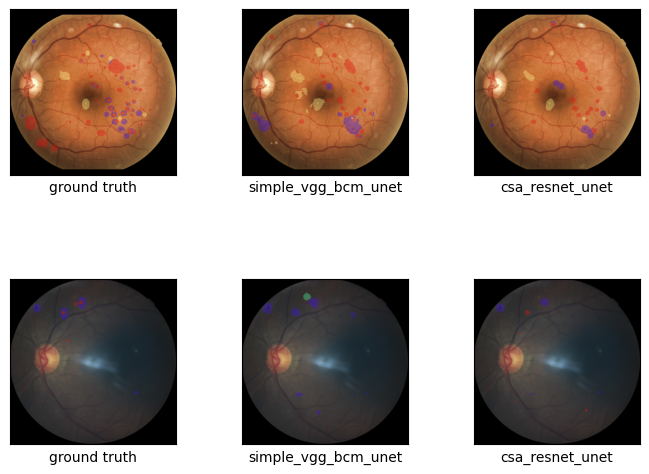

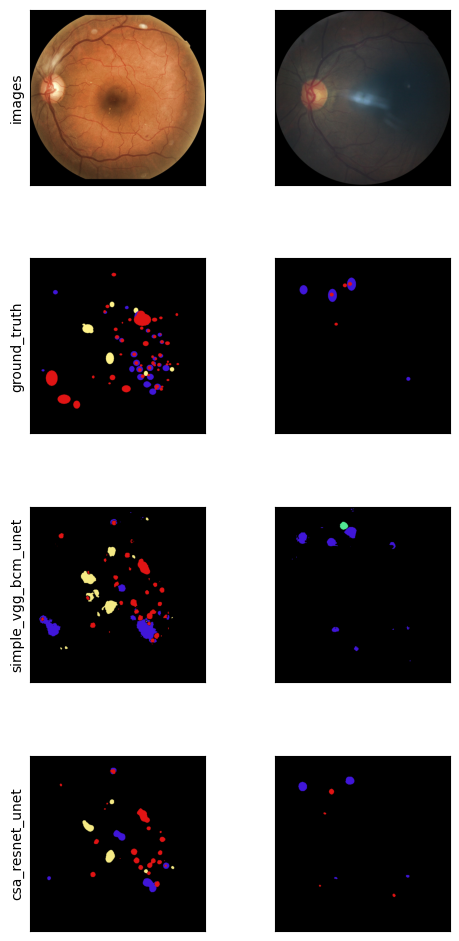

In [49]:
runner.qualitative(stub_name="qualitative", model_keys=["simple_vgg_bcm_unet", "csa_resnet_unet"], args=args)

## Interpretting Results

Different colors have been used to distinguish between the different lesions, the following explains which color corresonds to which lesion.

- image.png : microaneurysm
- image.png : hard exudates
- image.png : cotton wool spots
- image.png : retinal hemmorhages

## Quantitative Analysis

If required, you may run some quantitative tests by running the following code block, the results will be saved in the results folder. Please run collapsed.

- `quantitative_s1.csv` : This file compares segmentation metrics between the selected models, averaged over all classes
- `quantitative_s2.csv` : This files compares segmentation metrics between the selected models for each individual class
- `quantitative_s5.cs` : This file compares the F1 score between the models for each individual class.
- `quantitative_s6.csv` : This file compares the (Exact Match Ratio) EMR and Jaccard Score between the models.

*Please note that this is just for a demonstration and these results do not determine anything. This is due to the reason that only 8 images are used.*

['SENS', 'SPEC', 'IoU', 'DSC']
Working on : simple_vgg_bcm_unet...
Working on : csa_resnet_unet...
Creating final dict


<ipython-input-19-0cc86679783b>:403: RuntimeWarning: invalid value encountered in true_divide
  f1 = (2 * prec * recall) / (prec + recall)


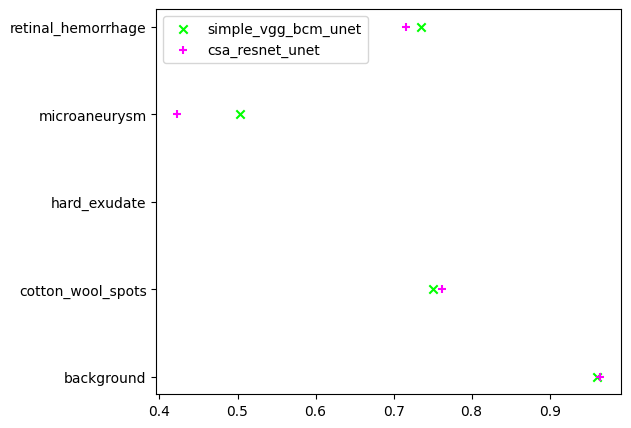

In [50]:
runner.quantative("quantative", list(model_spec.keys()))